### Inversion for elastic tensor with 7C seismometer

The inversion for the elastic tensor heavily relies on the estimation of the qP-velocity. Estimating this velocity is for translational and rotational sensors only possible if the qP's rotational signal is measured. However, it's magnitude is dwarfed against shear wave rotations and applying some noise to the data will lead to poor qP-velocity estimations. This is due to the nature of rotational motions that the ratio between rotational and translational components is only truely fit to determine shear wave velocities. Looking onto another technique, strain measurments are better suited to estimate pressure wave velocities.

In fact, it's already possible to do that with just one additional strain (rate) component. We choose $\dot\epsilon_{zz}$, the vertical component, as it is the most commonly measured direction in a bore hole.

It can be written down as:

$
\dot\epsilon_{zz} = -\frac{A\omega^2}{v}\nu_zn_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

We know the propagation direction $\nu$ from the polarization of rotational measurements. To extract the velocity $v$ from it, we cannot rotate the strainmeter as we do not have the complete measurements. Comparing it with the vertical translational component:

$
\ddot u_z = -A\omega^2n_z\exp(i\omega(t-\frac{x\cdot\nu}{v}))
$

we can calculcate the ratio:

$
\frac{\ddot u_z \nu_z}{\dot\epsilon_{zz}} = \frac{\ddot u_z}{\dot\epsilon_{zz}}\cos\theta = v
$

Noticeably, all three data types are combined to derive a single metric.
In theory, this is possible for each wave type, however it's best suited for P-waves.

Shear wave velocities are still computed using ratios between rotational and translational components.

During the inversion, unrealisitic p-wave velocities are not considered. If either the p-wave velocity is smaller than one of the shear wave velocity or three times greater, the event is discarded.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *
from scipy.signal import butter,filtfilt
from scipy.linalg import null_space

In [2]:
def estimate_velocity_7C(seis, nu,t, plot_rotated_seismo=False):
    nt = len(seis[0,:])
    r2d = 180/np.pi    
    theta, phi = get_angles(nu)
    R = np.zeros((3,3))
    r = [(1. + np.cos(phi)*np.sin(theta))/2,\
         (np.sin(phi)*np.sin(theta))/2,\
         np.cos(theta)/2]
    r_sum = 0
    for i in range(0,3):
        r_sum += r[i]**2
    for i in range(0,3):
        r[i] = r[i]/np.sqrt(r_sum)
        
    K_sq = [[-r[1]**2-r[2]**2,r[0]*r[1],r[0]*r[2]], \
            [r[0]*r[1],-r[0]**2-r[2]**2,r[1]*r[2]], \
            [r[0]*r[2],r[1]*r[2],-r[0]**2-r[1]**2]]
    
    R[0,0] = 1 + 2*K_sq[0][0]
    R[1,0] = 2*K_sq[1][0]
    R[2,0] = 2*K_sq[2][0]

    R[0,1] = 2*K_sq[0][1]
    R[1,1] = 1 + 2*K_sq[1][1]
    R[2,1] = 2*K_sq[2][1]

    R[0,2] = 2*K_sq[0][2]
    R[1,2] = 2*K_sq[1][2]
    R[2,2] = 1 + 2*K_sq[2][2]
    
    seis_new = np.zeros((6,nt))
    
    for k in range(0,3):
        seis_new[k,:]   = R[k,0]*seis[0,:]+R[k,1]*seis[1,:]+R[k,2]*seis[2,:]
        seis_new[k+3,:] = R[k,0]*seis[3,:]+R[k,1]*seis[4,:]+R[k,2]*seis[5,:]
    
    
    ip = np.argmax(seis_new[0,:])
    uz = seis[2,ip]
    ezz = seis[6,ip]
    qP = abs(uz*nu[2] / ezz)
    
    
    nang = 721
    xc  = np.zeros(nang)
    ang = np.linspace(0,180,nang)
    d2r = r2d**-1

    for i in range(nang):
        angle = ang[i]
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
        junk = np.corrcoef(xr, yr)
        xc[i] = junk[1,0]
        ang[i] = angle
        
    imax = np.argmax(xc)
    imax2 = np.argmin(xc)
    if abs(imax)<abs(imax2):
        imax = imax2
    amax = ang[imax]
    
    angle = amax
    xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
    yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
    
    seis_new[1,:] = xr
    seis_new[2,:] = yr
    
    xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
    yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]
    
    seis_new[4,:] = xrr
    seis_new[5,:] = yrr
    
    R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
    R = np.dot(R,R2.transpose())
        
    j1 = np.argmax(xrr)
    j1c = np.argmin(xrr)
    j2 = np.argmax(yrr)
    j2c = np.argmin(yrr)
    qS1 = abs(yr[j1]/xrr[j1])/2
    qS2 = abs(xr[j2]/yrr[j2])/2
    
    safety = nt//100
    if abs(j1-j2)<safety or abs(j1-j2c)<safety or abs(j1c-j2)<safety:    # if picks are from same peak!
        angle = 45.
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]

        seis_new[1,:] = xr
        seis_new[2,:] = yr

        xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
        yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]

        seis_new[4,:] = xrr
        seis_new[5,:] = yrr

        R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
        R = np.dot(R,R2.transpose())
        
        j1 = np.argmax(xrr)
        j2 = np.argmax(yrr)
        qS1 = abs(yr[j1]/xrr[j1])/2
        qS2 = abs(xr[j2]/yrr[j2])/2
    
        
    if qS1<qS2:
        qS1, qS2 = qS2, qS1
    
    vel_e = [qP, qS1, qS2]
    
    return vel_e, seis_new, R

In [3]:
medium = load_medium_list()
print(' ')
rand_med = load_random_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz
 
#0 isotropic
#1 cubic
#2 VTI
#3 tetragonal
#4 trigonal
#5 orthorhombic
#6 monoclinic
#7 triclinic


In [4]:
C, density = get_specific_VTI(medium[1])
#C, density = get_random_C(rand_med[5],20)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [5]:
ang1 = 0
ang2 = 0
ang3 = 0
C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:480: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


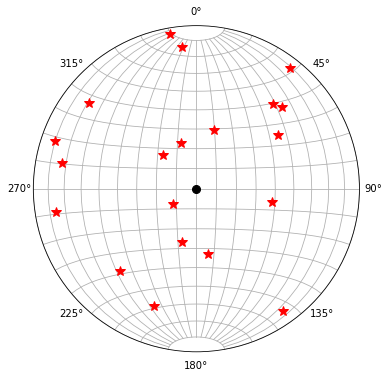

Estimated Elastic tensor - 7C:
[[47.2478969  19.9836687   9.03102458]
 [19.9836687  50.14233001  8.30079154]
 [ 9.03102458  8.30079154 31.22366974]]
[[  2.0444995    5.30541186  -5.41006453]
 [  6.81626682   4.52982942 -12.75224234]
 [ -1.03022255   0.92096673   1.43762501]]
[[ 5.43853623  3.25969708 -0.02707253]
 [ 3.25969708  8.74929924  0.03846182]
 [-0.02707253  0.03846182 10.30214597]]
 
 
misfit:
5.000847199742403
 
Used Events: 14
Rate: 70.0%
--------------------------------------------- 
Estimated Elastic tensor - 6C:
[[57.33477548 23.86142819 35.70923243]
 [23.86142819 68.91596923 32.02880544]
 [35.70923243 32.02880544 44.37017718]]
[[ -7.76758008   5.64057868 -10.98299129]
 [ -3.78562342   0.58492361   7.80125208]
 [ -1.18597296  -2.70982519  -8.333636  ]]
[[ 5.99111106  2.19848758 -2.72166157]
 [ 2.19848758  5.92186625 -5.72398141]
 [-2.72166157 -5.72398141 12.80922931]]
 
 
misfit:
8.614180342410117
 
Used Events: 9
Rate: 45.0%
--------------------------------------------- 

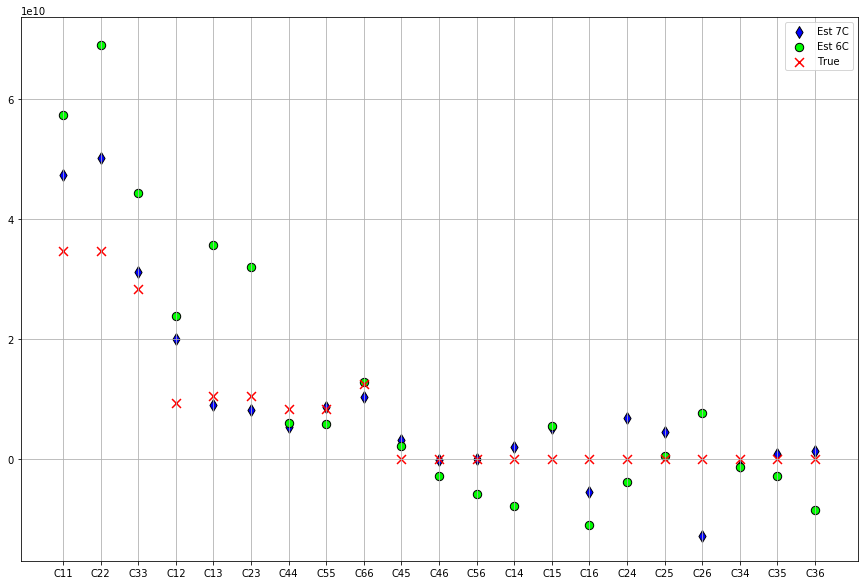

In [6]:
f = 10.
fs = 100.
SNR_dB_u = 0.
SNR_dB_r = 0.
SNR_dB_s = 0.
N = 20

## mode: assumed symmetry
mode = 'triclinic'

d = np.array([])
G = np.array([])
d2 = np.array([])
G2 = np.array([])
C_e = np.zeros((6,6))
C_e2 = np.zeros((6,6))
nu_used = []
nu_used2 = []
nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_nu_e = []
all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_strain(v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s)
    seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
    seis = lowpass(seis,f,fs)
    all_seis.append(seis)
    all_t.append(t)
    
    #if i%20==0:
    #    plot_7C(seis,t)
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    all_nu_e.append(nu_e)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    #print('#'+str(i))
    #print('True velocities')
    #print(max(vel),extract_slower_velocities(vel))
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used.append(nu_e)
        d,G = add_new_data(mode,d,G,nu_e,vel_e,n_trans,density)
     #   print('Estimated velocities - 7C')
     #   print(vel_e)
    
    vel_e,_,_ = estimate_velocity(seis[:6],nu_e,t)
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used2.append(nu_e)
        d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e,n_trans,density)
     #   print('Estimated velocities - 6C')
     #   print(vel_e)
    #print(' ')

Q = np.linalg.inv(np.dot(G.transpose(),G))         
m = np.dot(np.dot(Q,G.transpose()),d)
C_e = sort_elastic_coeff(mode,m)  
eps = np.dot(G,m)
 

Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
C_e2 = sort_elastic_coeff(mode,m2)  
eps2 = np.dot(G2,m2)
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

C_e = rotate_C(C_e,3,-ang3)
C_e = rotate_C(C_e,2,-ang2)
C_e = rotate_C(C_e,1,-ang1)

C_e2 = rotate_C(C_e2,3,-ang3)
C_e2 = rotate_C(C_e2,2,-ang2)
C_e2 = rotate_C(C_e2,1,-ang1)
    
    
print('Estimated Elastic tensor - 7C:')
print(C_e[:3,:3]*1e-9)
print(C_e[:3,3:]*1e-9)
print(C_e[3:,3:]*1e-9)
print(' ')
print(' ')
print('misfit:')
print(np.sqrt(np.dot(d-eps,d-eps))/len(nu_used)*1e-9)
print(' ')
print('Used Events: '+str(len(nu_used)))
print('Rate: '+str(round(len(nu_used)/N*100,2))+'%')
print('--------------------------------------------- ')
print('Estimated Elastic tensor - 6C:')
print(C_e2[:3,:3]*1e-9)
print(C_e2[:3,3:]*1e-9)
print(C_e2[3:,3:]*1e-9)
print(' ')
print(' ')
print('misfit:')
print(np.sqrt(np.dot(d2-eps2,d2-eps2))/len(nu_used2)*1e-9)
print(' ')
print('Used Events: '+str(len(nu_used2)))
print('Rate: '+str(round(len(nu_used2)/N*100,2))+'%')
print('--------------------------------------------- ')
print('Accurate Elastic tensor:')
print(C[:3,:3]*1e-9)
print(C[:3,3:]*1e-9)
print(C[3:,3:]*1e-9)
print(' ')

plot_tensor_estimation2(C,C_e,C_e2)

### 7C inversion - where do the errors come from?

There are three sources of errors. First, the estimation of the propagation direction $\nu$. Second, the estimation of the three polarizations $n$ and lastly the velocity estimations of pressure and shear waves.

The estimations:

    1) no analytical results
    2) accurate propagation direction
    3) accurate polarizations
    4) accurate propagation direction & polarizations
    5) accurate qS velocities
    6) accurate qP velocity
    7) accurate qP & qS velocities
    8) accurate velocities and prop. direction
    9) exact solution

In [7]:
C, density = get_specific_VTI(medium[1])
#C, density = get_random_C('orthorhombic',20)

taylor sandstone
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


In [8]:
ang1 = 0
ang2 = 0
ang3 = 0
C = rotate_C(C,1,ang1)
C = rotate_C(C,2,ang2)
C = rotate_C(C,3,ang3)

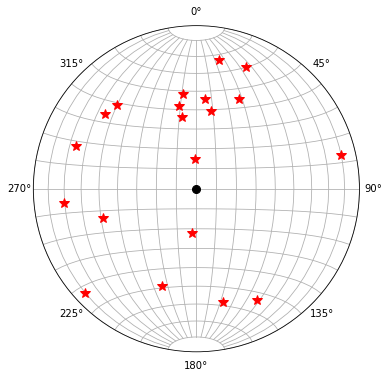

Used Events: 
1) 0.55
2) 0.75
3) 0.55
4) 0.75
5) 0.6
6) 1.0
7) 1.0
8) 1.0
9) 1.0
 
Misfit:
1) 3.2915648207328356
2) 2.6046583698613617
3) 2.9495267408759616
4) 2.3744191906052277
5) 3.4422901632827827
6) 1.8514934474226539
7) 1.6555596053742974
8) 0.769436851789214
9) 7.291479867975379e-15


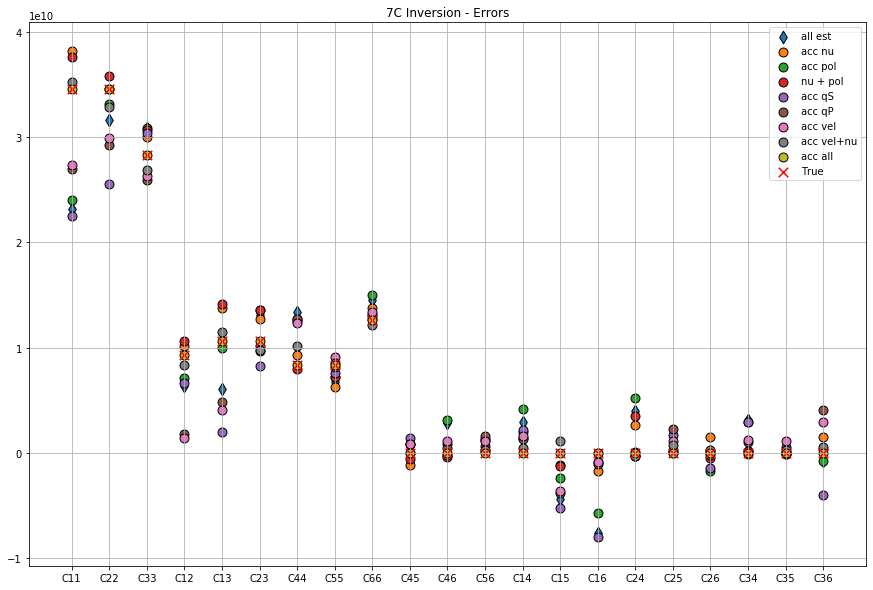

In [9]:
f = 10.
fs = 100.
SNR_dB_u = 0.
SNR_dB_r = 0.
SNR_dB_s = 0.
N = 20

## mode: assumed symmetry
mode = 'triclinic'

d1 = np.array([])
d2 = np.array([])
d3 = np.array([])
d4 = np.array([])
d5 = np.array([])
d6 = np.array([])
d7 = np.array([])
d8 = np.array([])
d9 = np.array([])

G1 = np.array([])
G2 = np.array([])
G3 = np.array([])
G4 = np.array([])
G5 = np.array([])
G6 = np.array([])
G7 = np.array([])
G8 = np.array([])
G9 = np.array([])

C_e1 = np.zeros((6,6))
C_e2 = np.zeros((6,6))
C_e3 = np.zeros((6,6))
C_e4 = np.zeros((6,6))
C_e5 = np.zeros((6,6))
C_e6 = np.zeros((6,6))
C_e7 = np.zeros((6,6))
C_e8 = np.zeros((6,6))
C_e9 = np.zeros((6,6))

nu_used1 = []
nu_used2 = []
nu_used3 = []
nu_used4 = []
nu_used5 = []
nu_used6 = []
nu_used7 = []
nu_used8 = []
nu_used9 = []

nus, gammas = get_direction('random',C,N+2,theta_e=0.,phi_e=0.)
plot_directions(nus[1:N+1])

all_seis = []
all_t = []
for i in range(1,N+1):
    vel, v = get_eigenvals(gammas[i], density)
    seis, t = get_seis_strain(v,vel,nus[i],f,fs)
    seis = make_some_noise(seis,SNR_dB_u,SNR_dB_r,SNR_dB_s)
    seis = np.array([seis[0,:],seis[1,:],seis[2,:],seis[3,:],seis[4,:],seis[5,:],seis[8,:]])
    seis = lowpass(seis,f,fs)
    all_seis.append(seis)
    all_t.append(t)
    
    iqP = np.argmax(vel)
    iqS2 = np.argmin(vel)
    for l in range(0,3):
        if iqP!=l and iqS2!=l:
            iqS1 = l
    
    #1) no analytical results
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used1.append(nu_e)
        d1,G1 = add_new_data(mode,d1,G1,nu_e,vel_e,n_trans,density)
        
    #2) accurate propagation direction        
    n_trans = get_polarizations(seis,'trans')
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used2.append(nu_e)
        d2,G2 = add_new_data(mode,d2,G2,nu_e,vel_e,n_trans,density)
    
    #3) accurate polarizations

    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used3.append(nu_e)
        d3,G3 = add_new_data(mode,d3,G3,nu_e,vel_e,n_trans,density)
        
    #4) accurate propagation direction & polarizations
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used4.append(nu_e)
        d4,G4 = add_new_data(mode,d4,G4,nu_e,vel_e,n_trans,density)
        
    #5) accurate qS velocities
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used5.append(nu_e)
        d5,G5 = add_new_data(mode,d5,G5,nu_e,vel_e,n_trans,density)
    
    #6) accurate qP velocity
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e,_,_ = estimate_velocity_7C(seis,nu_e,t)
    
    vel_e[0] = vel[iqP]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used6.append(nu_e)
        d6,G6 = add_new_data(mode,d6,G6,nu_e,vel_e,n_trans,density)
        
    #7) accurate qP & qS velocities 
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = get_propagation_direction(seis)
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used7.append(nu_e)
        d7,G7 = add_new_data(mode,d7,G7,nu_e,vel_e,n_trans,density)
        
    #9) Accurate Solution
    
    n_trans = np.array([v[:,iqP],v[:,iqS1],v[:,iqS2]])
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used8.append(nu_e)
        d8,G8 = add_new_data(mode,d8,G8,nu_e,vel_e,n_trans,density)
    
    #8) accurate velocities and prop. direction
    
    n_trans = get_polarizations(seis,'trans')
    nu_e = nus[i]
    vel_e[0] = vel[iqP]
    vel_e[1] = vel[iqS1]
    vel_e[2] = vel[iqS2]
    
    if vel_e[0]==0. or vel_e[0]<vel_e[1] or vel_e[0]/3 > vel_e[1]:
        pass
    else:
        nu_used9.append(nu_e)
        d9,G9 = add_new_data(mode,d9,G9,nu_e,vel_e,n_trans,density)

    

Q1 = np.linalg.inv(np.dot(G1.transpose(),G1))         
m1 = np.dot(np.dot(Q1,G1.transpose()),d1)
C_e1 = sort_elastic_coeff(mode,m1)  
eps1 = np.dot(G1,m1) 

Q2 = np.linalg.inv(np.dot(G2.transpose(),G2))         
m2 = np.dot(np.dot(Q2,G2.transpose()),d2)
C_e2 = sort_elastic_coeff(mode,m2)  
eps2 = np.dot(G2,m2)

Q3 = np.linalg.inv(np.dot(G3.transpose(),G3))         
m3 = np.dot(np.dot(Q3,G3.transpose()),d3)
C_e3 = sort_elastic_coeff(mode,m3)  
eps3 = np.dot(G3,m3)

Q4 = np.linalg.inv(np.dot(G4.transpose(),G4))         
m4 = np.dot(np.dot(Q4,G4.transpose()),d4)
C_e4 = sort_elastic_coeff(mode,m4)  
eps4 = np.dot(G4,m4)

Q5 = np.linalg.inv(np.dot(G5.transpose(),G5))         
m5 = np.dot(np.dot(Q5,G5.transpose()),d5)
C_e5 = sort_elastic_coeff(mode,m5)  
eps5 = np.dot(G5,m5)

Q6 = np.linalg.inv(np.dot(G6.transpose(),G6))         
m6 = np.dot(np.dot(Q6,G6.transpose()),d6)
C_e6 = sort_elastic_coeff(mode,m6)  
eps6 = np.dot(G6,m6)

Q7 = np.linalg.inv(np.dot(G7.transpose(),G7))         
m7 = np.dot(np.dot(Q7,G7.transpose()),d7)
C_e7 = sort_elastic_coeff(mode,m7)  
eps7 = np.dot(G7,m7)

Q8 = np.linalg.inv(np.dot(G8.transpose(),G8))         
m8 = np.dot(np.dot(Q8,G8.transpose()),d8)
C_e8 = sort_elastic_coeff(mode,m8)  
eps8 = np.dot(G8,m8)

Q9 = np.linalg.inv(np.dot(G9.transpose(),G9))         
m9 = np.dot(np.dot(Q9,G9.transpose()),d9)
C_e9 = sort_elastic_coeff(mode,m9)  
eps9 = np.dot(G9,m9)
    
C = rotate_C(C,3,-ang3)
C = rotate_C(C,2,-ang2)
C = rotate_C(C,1,-ang1)

C_e1 = rotate_C(C_e1,3,-ang3)
C_e1 = rotate_C(C_e1,2,-ang2)
C_e1 = rotate_C(C_e1,1,-ang1)

C_e2 = rotate_C(C_e2,3,-ang3)
C_e2 = rotate_C(C_e2,2,-ang2)
C_e2 = rotate_C(C_e2,1,-ang1)

C_e3 = rotate_C(C_e3,3,-ang3)
C_e3 = rotate_C(C_e3,2,-ang2)
C_e3 = rotate_C(C_e3,1,-ang1)

C_e4 = rotate_C(C_e4,3,-ang3)
C_e4 = rotate_C(C_e4,2,-ang2)
C_e4 = rotate_C(C_e4,1,-ang1)

C_e5 = rotate_C(C_e5,3,-ang3)
C_e5 = rotate_C(C_e5,2,-ang2)
C_e5 = rotate_C(C_e5,1,-ang1)

C_e6 = rotate_C(C_e6,3,-ang3)
C_e6 = rotate_C(C_e6,2,-ang2)
C_e6 = rotate_C(C_e6,1,-ang1)

C_e7 = rotate_C(C_e7,3,-ang3)
C_e7 = rotate_C(C_e7,2,-ang2)
C_e7 = rotate_C(C_e7,1,-ang1)

C_e8 = rotate_C(C_e8,3,-ang3)
C_e8 = rotate_C(C_e8,2,-ang2)
C_e8 = rotate_C(C_e8,1,-ang1)

C_e9 = rotate_C(C_e9,3,-ang3)
C_e9 = rotate_C(C_e9,2,-ang2)
C_e9 = rotate_C(C_e9,1,-ang1)

print('Used Events: ')
print('1) '+str(len(nu_used1)/N))
print('2) '+str(len(nu_used2)/N))
print('3) '+str(len(nu_used3)/N))
print('4) '+str(len(nu_used4)/N))
print('5) '+str(len(nu_used5)/N))
print('6) '+str(len(nu_used6)/N))
print('7) '+str(len(nu_used7)/N))
print('8) '+str(len(nu_used9)/N))
print('9) '+str(len(nu_used8)/N))
print(' ')
    
print('Misfit:')
print('1) '+str(np.sqrt(np.dot(d1-eps1,d1-eps1))*1e-9/len(nu_used1)))
print('2) '+str(np.sqrt(np.dot(d2-eps2,d2-eps2))*1e-9/len(nu_used2)))
print('3) '+str(np.sqrt(np.dot(d3-eps3,d3-eps3))*1e-9/len(nu_used3)))
print('4) '+str(np.sqrt(np.dot(d4-eps4,d4-eps4))*1e-9/len(nu_used4)))
print('5) '+str(np.sqrt(np.dot(d5-eps5,d5-eps5))*1e-9/len(nu_used5)))
print('6) '+str(np.sqrt(np.dot(d6-eps6,d6-eps6))*1e-9/len(nu_used6)))
print('7) '+str(np.sqrt(np.dot(d7-eps7,d7-eps7))*1e-9/len(nu_used7)))
print('8) '+str(np.sqrt(np.dot(d9-eps9,d9-eps9))*1e-9/len(nu_used9)))
print('9) '+str(np.sqrt(np.dot(d8-eps8,d8-eps8))*1e-9/len(nu_used8)))


param = ['C11','C22','C33','C12','C13','C23','C44','C55','C66','C45','C46','C56','C14','C15','C16','C24',\
         'C25','C26','C34','C35','C36']
c_true = [C[0,0],C[1,1],C[2,2],C[0,1],C[0,2],C[1,2],C[3,3],C[4,4],C[5,5],C[3,4],C[3,5],C[4,5],C[0,3],C[0,4],\
          C[0,5],C[1,3],C[1,4],C[1,5],C[2,3],C[2,4],C[2,5]]
c_est1 = [C_e1[0,0],C_e1[1,1],C_e1[2,2],C_e1[0,1],C_e1[0,2],C_e1[1,2],C_e1[3,3],C_e1[4,4],C_e1[5,5],C_e1[3,4],\
         C_e1[3,5],C_e1[4,5],C_e1[0,3],C_e1[0,4],C_e1[0,5],C_e1[1,3],C_e1[1,4],C_e1[1,5],C_e1[2,3],C_e1[2,4],\
         C_e1[2,5]]
c_est2 = [C_e2[0,0],C_e2[1,1],C_e2[2,2],C_e2[0,1],C_e2[0,2],C_e2[1,2],C_e2[3,3],C_e2[4,4],C_e2[5,5],C_e2[3,4],\
          C_e2[3,5],C_e2[4,5],C_e2[0,3],C_e2[0,4],C_e2[0,5],C_e2[1,3],C_e2[1,4],C_e2[1,5],C_e2[2,3],C_e2[2,4],\
          C_e2[2,5]]
c_est3 = [C_e3[0,0],C_e3[1,1],C_e3[2,2],C_e3[0,1],C_e3[0,2],C_e3[1,2],C_e3[3,3],C_e3[4,4],C_e3[5,5],C_e3[3,4],\
          C_e3[3,5],C_e3[4,5],C_e3[0,3],C_e3[0,4],C_e3[0,5],C_e3[1,3],C_e3[1,4],C_e3[1,5],C_e3[2,3],C_e3[2,4],\
          C_e3[2,5]]
c_est4 = [C_e4[0,0],C_e4[1,1],C_e4[2,2],C_e4[0,1],C_e4[0,2],C_e4[1,2],C_e4[3,3],C_e4[4,4],C_e4[5,5],C_e4[3,4],\
          C_e4[3,5],C_e4[4,5],C_e4[0,3],C_e4[0,4],C_e4[0,5],C_e4[1,3],C_e4[1,4],C_e4[1,5],C_e4[2,3],C_e4[2,4],\
          C_e4[2,5]]
c_est5 = [C_e5[0,0],C_e5[1,1],C_e5[2,2],C_e5[0,1],C_e5[0,2],C_e5[1,2],C_e5[3,3],C_e5[4,4],C_e5[5,5],C_e5[3,4],\
          C_e5[3,5],C_e5[4,5],C_e5[0,3],C_e5[0,4],C_e5[0,5],C_e5[1,3],C_e5[1,4],C_e5[1,5],C_e5[2,3],C_e5[2,4],\
          C_e5[2,5]]
c_est6 = [C_e6[0,0],C_e6[1,1],C_e6[2,2],C_e6[0,1],C_e6[0,2],C_e6[1,2],C_e6[3,3],C_e6[4,4],C_e6[5,5],C_e6[3,4],\
          C_e6[3,5],C_e6[4,5],C_e6[0,3],C_e6[0,4],C_e6[0,5],C_e6[1,3],C_e6[1,4],C_e6[1,5],C_e6[2,3],C_e6[2,4],\
          C_e6[2,5]]
c_est7 = [C_e7[0,0],C_e7[1,1],C_e7[2,2],C_e7[0,1],C_e7[0,2],C_e7[1,2],C_e7[3,3],C_e7[4,4],C_e7[5,5],C_e7[3,4],\
          C_e7[3,5],C_e7[4,5],C_e7[0,3],C_e7[0,4],C_e7[0,5],C_e7[1,3],C_e7[1,4],C_e7[1,5],C_e7[2,3],C_e7[2,4],\
          C_e7[2,5]]
c_est8 = [C_e8[0,0],C_e8[1,1],C_e8[2,2],C_e8[0,1],C_e8[0,2],C_e8[1,2],C_e8[3,3],C_e8[4,4],C_e8[5,5],C_e8[3,4],\
          C_e8[3,5],C_e8[4,5],C_e8[0,3],C_e8[0,4],C_e8[0,5],C_e8[1,3],C_e8[1,4],C_e8[1,5],C_e8[2,3],C_e8[2,4],\
          C_e8[2,5]]

c_est9 = [C_e9[0,0],C_e9[1,1],C_e9[2,2],C_e9[0,1],C_e9[0,2],C_e9[1,2],C_e9[3,3],C_e9[4,4],C_e9[5,5],C_e9[3,4],\
          C_e9[3,5],C_e9[4,5],C_e9[0,3],C_e9[0,4],C_e9[0,5],C_e9[1,3],C_e9[1,4],C_e9[1,5],C_e9[2,3],C_e9[2,4],\
          C_e9[2,5]]

plt.figure(figsize=(15,10))
plt.title('7C Inversion - Errors')
plt.scatter(param,c_est1,label='all est',marker='d',s=80,edgecolors='black')
plt.scatter(param,c_est2,label='acc nu',s=80,edgecolors='black')
plt.scatter(param,c_est3,label='acc pol',s=80,edgecolors='black')
plt.scatter(param,c_est4,label='nu + pol',s=80,edgecolors='black')
plt.scatter(param,c_est5,label='acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='acc qP',s=80,edgecolors='black')
plt.scatter(param,c_est7,label='acc vel',s=80,edgecolors='black')
plt.scatter(param,c_est9,label='acc vel+nu',s=80,edgecolors='black')
plt.scatter(param,c_est8,label='acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()

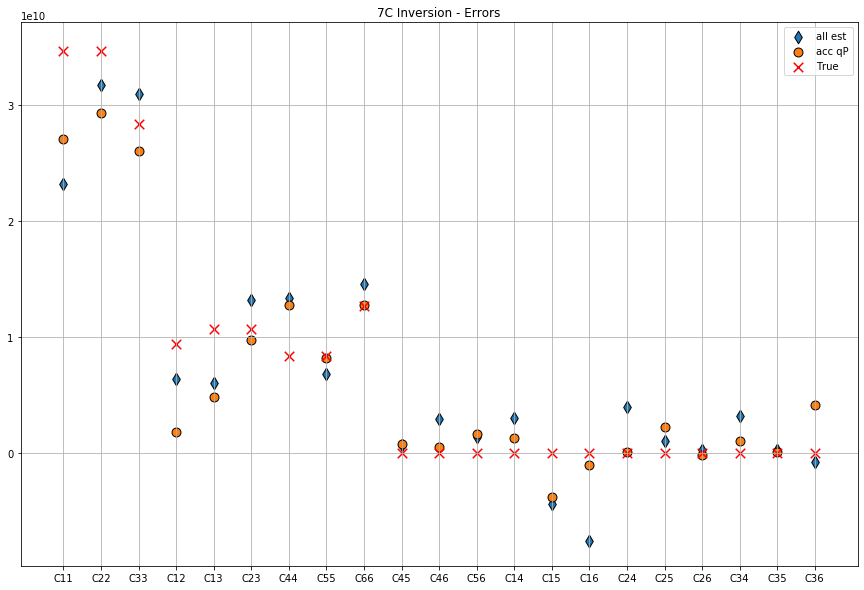

In [10]:
plt.figure(figsize=(15,10))
plt.title('7C Inversion - Errors')
plt.scatter(param,c_est1,label='all est',marker='d',s=80,edgecolors='black')
#plt.scatter(param,c_est2,label='acc nu',s=80,edgecolors='black')
#plt.scatter(param,c_est3,label='acc pol',s=80,edgecolors='black')
#plt.scatter(param,c_est4,label='nu + pol',s=80,edgecolors='black')
#plt.scatter(param,c_est5,label='acc qS',s=80,edgecolors='black')
plt.scatter(param,c_est6,label='acc qP',s=80,edgecolors='black')
#plt.scatter(param,c_est7,label='acc vel',s=80,edgecolors='black')
#plt.scatter(param,c_est9,label='acc vel+nu',s=80,edgecolors='black')
#plt.scatter(param,c_est8,label='acc all',s=80,edgecolors='black')
plt.scatter(param,c_true,color='red',marker='x',label='True',s=90,edgecolors='black')
plt.grid()
plt.legend(loc=1)
plt.show()